In [1]:
import os
import shutil
from pathlib import Path
import numpy as np
import random

np.random.seed(0) 
random.seed(0)


In [2]:
import yaml
import shutil
import json
import numpy as np
from pathlib import Path

try:
    import torch
    from ultralytics import YOLO
    torch_available = True
except ImportError:
    print("PyTorch/YOLO não disponível - apenas processamento de dataset")
    torch_available = False

try:
    from PIL import Image
    pil_available = True
except ImportError:
    print("PIL não disponível")
    pil_available = False

class SurgicalHandsIntegrator:
    def __init__(self, hands_dataset_path):
        """
        Integrador para dataset de mãos cirúrgicas Surgical Hands RELEASE
        """
        self.hands_dataset_path = Path(hands_dataset_path)
        self.images_dir = self.hands_dataset_path / "images"
        self.annotations_file = self.hands_dataset_path / "annotations.json"
        
        # Mapeamento específico para Surgical Hands RELEASE
        self.hand_class_mapping = {
            'left_hand': 4,
            'right_hand': 5,
            0: 4,  # left_hand no dataset original
            1: 5   # right_hand no dataset original
        }

    def load_hand_annotations(self):
        """Carrega anotações do Surgical Hands RELEASE dataset"""
        try:
            #print(f"Carregando anotações de: {self.annotations_file}")
            with open(self.annotations_file, 'r', encoding='utf-8') as f:
                annotations = json.load(f)
            
            #print(f"✅ Anotações carregadas com sucesso")
            #print(f"Tipo de dados: {type(annotations)}")
            
            if isinstance(annotations, dict):
                #print(f"Sequências encontradas: {len(annotations)}")
                
                # Debug das primeiras sequências
                for i, (seq_name, seq_data) in enumerate(list(annotations.items())[:3]):
                    #print(f"  Sequência {i+1}: {seq_name}")
                    if isinstance(seq_data, dict):
                        #print(f"    Chaves: {list(seq_data.keys())}")
                        if 'images' in seq_data:
                            print(f"    Imagens: {len(seq_data['images'])}")
                        if 'annotations' in seq_data:
                            print(f"    Anotações: {len(seq_data['annotations'])}")
                
                return annotations
            else:
                #print(f"❌ Formato inesperado: {type(annotations)}")
                return None
                
        except Exception as e:
            print(f"❌ Erro ao carregar anotações: {e}")
            return None

    def find_all_images(self):
        """Encontra todas as imagens no dataset"""
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
        all_images = []
        
        #print(f"Procurando imagens em: {self.images_dir}")
        
        if self.images_dir.exists():
            # Procurar em subpastas (cada pasta é uma sequência)
            for subfolder in self.images_dir.iterdir():
                if subfolder.is_dir():
                    #print(f"Verificando sequência: {subfolder.name}")
                    folder_images = []
                    
                    for ext in image_extensions:
                        found = list(subfolder.glob(ext))
                        found.extend(list(subfolder.glob(ext.upper())))
                        folder_images.extend(found)
                    
                    #print(f"  Encontradas {len(folder_images)} imagens")
                    all_images.extend(folder_images)
        
        #print(f"Total de imagens encontradas: {len(all_images)}")
        return all_images

    def get_sequence_annotations(self, img_file, all_annotations):
        """Busca anotações para uma imagem específica baseada na sequência"""
        # Obter nome da pasta (sequência)
        sequence_name = img_file.parent.name
        img_filename = img_file.name
        
        #print(f"🔍 Buscando anotações para: {img_filename} na sequência: {sequence_name}")
        
        # Buscar dados da sequência
        sequence_data = None
        matched_sequence = None
        
        # Tentar match exato primeiro
        if sequence_name in all_annotations:
            sequence_data = all_annotations[sequence_name]
            matched_sequence = sequence_name
            #print(f"  ✅ Sequência encontrada: {matched_sequence}")
        else:
            # Tentar match parcial
            for seq_key in all_annotations.keys():
                if sequence_name in seq_key or seq_key in sequence_name:
                    sequence_data = all_annotations[seq_key]
                    matched_sequence = seq_key
                    #print(f"  ✅ Sequência encontrada via match parcial: {matched_sequence}")
                    break
        
        if sequence_data is None:
            #print(f"  ❌ Sequência não encontrada")
            #print(f"  Sequências disponíveis: {list(all_annotations.keys())[:5]}...")
            return []
        
        # Verificar estrutura da sequência
        if not isinstance(sequence_data, dict) or 'images' not in sequence_data or 'annotations' not in sequence_data:
            #print(f"  ❌ Estrutura da sequência inválida: {list(sequence_data.keys()) if isinstance(sequence_data, dict) else type(sequence_data)}")
            return []
        
        images_list = sequence_data['images']
        annotations_list = sequence_data['annotations']
        
        #print(f"  Sequência tem {len(images_list)} imagens e {len(annotations_list)} anotações")
        
        # Encontrar a imagem específica
        target_image_id = None
        target_image_info = None
        
        for img_info in images_list:
            file_name = img_info.get('file_name', '')
            
            # Tentar diferentes formas de matching
            if (img_filename == file_name or 
                img_file.stem == Path(file_name).stem or
                img_filename in file_name or 
                file_name in img_filename):
                target_image_id = img_info.get('id')
                target_image_info = img_info
                #print(f"  ✅ Imagem encontrada: {file_name} (ID: {target_image_id})")
                break
        
        if target_image_id is None:
            #print(f"  ❌ Imagem não encontrada na sequência")
            available_files = [img.get('file_name', 'sem_nome') for img in images_list[:3]]
            #print(f"  Imagens disponíveis na sequência: {available_files}...")
            return []
        
        # Buscar anotações para esta imagem
        image_annotations = []
        for ann in annotations_list:
            if ann.get('image_id') == target_image_id:
                image_annotations.append(ann)
        
        #print(f"  Encontradas {len(image_annotations)} anotações para esta imagem")
        
        if not image_annotations:
            return []
        
        # Obter dimensões da imagem
        try:
            if pil_available:
                pil_image = Image.open(img_file)
                w, h = pil_image.size
            else:
                # Usar dimensões do JSON se disponível
                w = target_image_info.get('width', 640)
                h = target_image_info.get('height', 480)
            
            #print(f"  Dimensões da imagem: {w}x{h}")
            
            # Converter para formato YOLO
            yolo_annotations = self.convert_coco_to_yolo(image_annotations, w, h)
            return yolo_annotations
            
        except Exception as e:
            print(f"  ❌ Erro ao processar anotações: {e}")
            return []

    def convert_coco_to_yolo(self, annotations, image_width, image_height):
        """Converte anotações COCO para formato YOLO"""
        yolo_annotations = []
        
        #print(f"    🔄 Convertendo {len(annotations)} anotações COCO para YOLO")
        
        for i, ann in enumerate(annotations):
            try:
                # Extrair bbox no formato COCO [x, y, width, height]
                bbox = ann.get('bbox', [])
                if len(bbox) != 4:
                    #print(f"      ⚠️ Anotação {i+1}: bbox inválida {bbox}")
                    continue
                
                x, y, w, h = bbox
                #print(f"      Anotação {i+1}: bbox COCO = [{x}, {y}, {w}, {h}]")
                
                # Obter categoria
                category_id = ann.get('category_id', 0)
                #print(f"      Categoria ID: {category_id}")
                
                # Mapear para classe YOLO
                if category_id in self.hand_class_mapping:
                    class_id = self.hand_class_mapping[category_id]
                else:
                    # Fallback: usar posição para determinar esquerda/direita
                    center_x = x + w / 2
                    class_id = 4 if center_x < image_width / 2 else 5
                    #print(f"      Usando heurística de posição: centro_x={center_x}, classe={class_id}")
                
                # Converter para formato YOLO normalizado
                x_center = (x + w / 2) / image_width
                y_center = (y + h / 2) / image_height
                width_norm = w / image_width
                height_norm = h / image_height
                
                #print(f"      YOLO normalizado: [{class_id}, {x_center:.3f}, {y_center:.3f}, {width_norm:.3f}, {height_norm:.3f}]")
                
                # Validar coordenadas
                if (0 <= x_center <= 1 and 0 <= y_center <= 1 and 
                    0 < width_norm <= 1 and 0 < height_norm <= 1):
                    yolo_annotations.append([class_id, x_center, y_center, width_norm, height_norm])
                    #print(f"      ✅ Anotação válida adicionada")
                else:
                    print(f"      ❌ Coordenadas inválidas")
                
            except Exception as e:
                print(f"      ❌ Erro ao processar anotação {i+1}: {e}")
                continue
        
        #print(f"    Total de anotações YOLO válidas: {len(yolo_annotations)}")
        return yolo_annotations

    def process_hands_dataset(self, output_dir):
        """Processa o dataset Surgical Hands RELEASE"""
        output_dir = Path(output_dir)
        (output_dir / "images").mkdir(parents=True, exist_ok=True)
        (output_dir / "labels").mkdir(parents=True, exist_ok=True)
        
        # Carregar todas as anotações
        all_annotations = self.load_hand_annotations()
        if not all_annotations:
            print("❌ ERRO: Não foi possível carregar annotations.json")
            return 0
        
        # Encontrar todas as imagens
        all_images = self.find_all_images()
        if not all_images:
            print("❌ Nenhuma imagem encontrada!")
            return 0
        
        processed_count = 0
        
        print(f"\n🚀 Processando {len(all_images)} imagens...")
        
        for img_file in all_images:
            try:
                # Buscar anotações para esta imagem
                hand_detections = self.get_sequence_annotations(img_file, all_annotations)
                
                if hand_detections:
                    print(f"✅ {img_file.name} ({len(hand_detections)} mãos detectadas)")
                    
                    # Copiar/converter imagem
                    new_img_name = f"hand_{processed_count:06d}.jpg"
                    
                    if pil_available and img_file.suffix.lower() != '.jpg':
                        pil_image = Image.open(img_file).convert('RGB')
                        pil_image.save(output_dir / "images" / new_img_name, 'JPEG')
                    else:
                        shutil.copy(img_file, output_dir / "images" / new_img_name)
                    
                    # Salvar labels
                    label_file = output_dir / "labels" / f"hand_{processed_count:06d}.txt"
                    with open(label_file, 'w') as f:
                        for detection in hand_detections:
                            line = ' '.join(map(str, detection))
                            f.write(line + '\n')
                    
                    processed_count += 1
                    
                    if processed_count % 50 == 0:
                        print(f"📊 Processadas {processed_count} imagens")
                else:
                    print(f"⚠️ {img_file.name} - sem anotações de mãos")
            
            except Exception as e:
                print(f"❌ Erro ao processar {img_file.name}: {e}")
                continue
        
        print(f"\n🎉 Dataset de mãos processado:")
        print(f"   Total: {processed_count} imagens com anotações válidas")
        print(f"   Taxa de sucesso: {(processed_count/len(all_images)*100):.1f}%")
        
        return processed_count

class AdvancedYOLOTrainer:
    def __init__(self, base_model):
        self.base_model = base_model
        if torch_available:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = "cpu"
        
    def prepare_combined_dataset(self, surgical_data_path, hands_dataset_path):
        """Prepara dataset combinado com instrumentos cirúrgicos e mãos"""
        print("=== Preparando Dataset Combinado ===")
        
        # Diretório de saída
        combined_dir = Path("combined_surgical_dataset")
        (combined_dir / "images/train").mkdir(parents=True, exist_ok=True)
        (combined_dir / "labels/train").mkdir(parents=True, exist_ok=True)
        
        # 1. Processar dataset original de instrumentos
        print("1. Processando dataset de instrumentos...")
        surgical_path = Path(surgical_data_path)
        
        instrument_count = 0
        if (surgical_path / "images/train").exists():
            for img_file in (surgical_path / "images/train").glob("*.jpg"):
                # Copiar imagem
                shutil.copy(img_file, combined_dir / "images/train" / img_file.name)
                
                # Copiar/criar label
                label_file = surgical_path / "labels/train" / f"{img_file.stem}.txt"
                target_label = combined_dir / "labels/train" / f"{img_file.stem}.txt"
                
                if label_file.exists():
                    shutil.copy(label_file, target_label)
                else:
                    target_label.touch()
                
                instrument_count += 1
        
        print(f"✅ Instrumentos processados: {instrument_count}")
        
        # 2. Processar dataset de mãos
        print("2. Processando dataset de mãos...")
        hands_integrator = SurgicalHandsIntegrator(hands_dataset_path)
        
        # Processar mãos para diretório temporário
        temp_hands_dir = Path("temp_hands_processed")
        hands_count = hands_integrator.process_hands_dataset(temp_hands_dir)
        
        # Mover imagens e labels processados para dataset combinado
        if temp_hands_dir.exists() and hands_count > 0:
            for img_file in (temp_hands_dir / "images").glob("*.jpg"):
                shutil.move(img_file, combined_dir / "images/train" / img_file.name)
            
            for label_file in (temp_hands_dir / "labels").glob("*.txt"):
                shutil.move(label_file, combined_dir / "labels/train" / label_file.name)
            
            # Limpar diretório temporário
            shutil.rmtree(temp_hands_dir)
        
        print(f"✅ Mãos processadas: {hands_count}")
        
        # 3. Criar configuração do dataset
        total_images = instrument_count + hands_count
        
        data_config = {
            'path': str(combined_dir.absolute()),
            'train': 'images/train',
            'val': 'images/train',
            'nc': 6,
            'names': ['needle', 'clamp', 'curved_scissor', 'straight_scissor', 'left_hand', 'right_hand']
        }
        
        with open(combined_dir / "data.yaml", "w") as f:
            yaml.dump(data_config, f)
        
        print(f"\n=== Dataset Combinado Criado ===")
        print(f"📊 Total de imagens: {total_images}")
        print(f"🔧 Instrumentos: {instrument_count}")
        print(f"👋 Mãos: {hands_count}")
        print(f"🏷️ Classes: {data_config['names']}")
        
        return combined_dir

    def create_advanced_config(self):
        """Configuração avançada para treino YOLO"""
        config = {
            'lr0': 0.001,
            'lrf': 0.01,
            'momentum': 0.98,
            'weight_decay': 0.0005,
            'warmup_epochs': 5,
            'warmup_momentum': 0.8,
            'warmup_bias_lr': 0.1,
            'box': 7.5,
            'cls': 0.5,
            'dfl': 1.5,
            'epochs': 50,
            'batch': 8,
            'imgsz': 640,
            'patience': 50,
            'save_period': 10,
            'hsv_h': 0.015,
            'hsv_s': 0.7,
            'hsv_v': 0.4,
            'degrees': 15.0,
            'translate': 0.1,
            'scale': 0.5,
            'shear': 5.0,
            'perspective': 0.0001,
            'flipud': 0.0,
            'fliplr': 0.5,
            'mosaic': 1.0,
            'mixup': 0.15,
            'copy_paste': 0.3,
            'dropout': 0.2,
            'val': True,
            'plots': True,
            'verbose': True
        }
        return config

    def train_with_advanced_features(self, data_path, use_optimization=True):
        """Treina o modelo com configurações avançadas"""
        if not torch_available:
            print("❌ PyTorch não disponível - não é possível treinar")
            return None, 0.0
        
        config = self.create_advanced_config()
        
        print("🚀 Iniciando treino com dataset combinado...")
        model = YOLO(self.base_model)
        
        results = model.train(
            data=data_path,
            **config
        )
        
        best_map = results.results_dict.get('metrics/mAP50(B)', 0.0)
        best_model_path = 'runs/detect/train/weights/best.pt'
        
        return best_model_path, best_map

def main():
    """Função principal"""
    
    # Configurações de caminhos
    surgical_dataset_path = Path("yolo_dataset")
    hands_dataset_path = Path("surgical_hands_release")
    
    # Verificar se os datasets existem
    if not surgical_dataset_path.exists():
        print(f"❌ Dataset de instrumentos não encontrado: {surgical_dataset_path}")
        return
    
    if not hands_dataset_path.exists():
        print(f"❌ Dataset de mãos não encontrado: {hands_dataset_path}")
        return
    
    # Verificar se annotations.json existe
    annotations_file = hands_dataset_path / "annotations.json"
    if not annotations_file.exists():
        print(f"❌ Arquivo de anotações não encontrado: {annotations_file}")
        print("Este código requer o arquivo annotations.json do Surgical Hands RELEASE")
        return
    
    # Preparar dataset original se necessário
    print("📁 Preparando dataset original de instrumentos...")
    yolo_dir = Path("yolo_dataset")
    if not yolo_dir.exists():
        (yolo_dir / "images/train").mkdir(parents=True, exist_ok=True)
        (yolo_dir / "labels/train").mkdir(parents=True, exist_ok=True)
        
        # Copiar dados originais
        img_dir = surgical_dataset_path / "Images"
        label_dir = surgical_dataset_path / "Labels/label object names"
        
        if img_dir.exists() and label_dir.exists():
            for label_file in label_dir.glob("*.txt"):
                img_id = label_file.stem
                img_file = img_dir / f"{img_id}.jpg"
                if img_file.exists():
                    shutil.copy(img_file, yolo_dir / "images/train" / f"{img_id}.jpg")
                    shutil.copy(label_file, yolo_dir / "labels/train" / f"{img_id}.txt")
    
    # Inicializar trainer
    trainer = AdvancedYOLOTrainer("yolo11n.pt")
    
    # Preparar dataset combinado
    combined_dataset_path = trainer.prepare_combined_dataset(
        surgical_data_path=yolo_dir,
        hands_dataset_path=hands_dataset_path
    )
    
    # Treinar modelo se PyTorch estiver disponível
    if torch_available:
        data_config_path = combined_dataset_path / "data.yaml"
        best_model_path, best_map = trainer.train_with_advanced_features(
            data_path=data_config_path,
            use_optimization=False
        )
        
        print(f"\n=== TREINO CONCLUÍDO ===")
        print(f"🎯 Melhor mAP@0.5: {best_map:.4f}")
        print(f"💾 Modelo salvo em: {best_model_path}")
        
        print("\n=== SISTEMA DE TRACKING PRONTO ===")
        print("🏷️ Classes detectáveis:")
        print("  0: needle (agulha)")
        print("  1: clamp (pinça)")
        print("  2: curved_scissor (tesoura curva)")
        print("  3: straight_scissor (tesoura reta)")
        print("  4: left_hand (mão esquerda)")
        print("  5: right_hand (mão direita)")
    else:
        print("\n⚠️ PyTorch não disponível - apenas processamento de dataset concluído")
        print("📦 Dataset combinado criado em:", combined_dataset_path)

In [3]:
if __name__ == "__main__":
    main()

📁 Preparando dataset original de instrumentos...
=== Preparando Dataset Combinado ===
1. Processando dataset de instrumentos...
✅ Instrumentos processados: 3009
2. Processando dataset de mãos...
    Imagens: 113
    Anotações: 58
    Imagens: 95
    Anotações: 60
    Imagens: 104
    Anotações: 57

🚀 Processando 5138 imagens...
      ❌ Coordenadas inválidas
      ❌ Coordenadas inválidas
✅ 000016.png (4 mãos detectadas)
      ❌ Coordenadas inválidas
      ❌ Coordenadas inválidas
✅ 000006.png (4 mãos detectadas)
⚠️ 000055.png - sem anotações de mãos
⚠️ 000043.png - sem anotações de mãos
⚠️ 000039.png - sem anotações de mãos
      ❌ Coordenadas inválidas
      ❌ Coordenadas inválidas
✅ 000008.png (4 mãos detectadas)
      ❌ Coordenadas inválidas
      ❌ Coordenadas inválidas
✅ 000025.png (4 mãos detectadas)
⚠️ 000052.png - sem anotações de mãos
⚠️ 000058.png - sem anotações de mãos
⚠️ 000060.png - sem anotações de mãos
⚠️ 000050.png - sem anotações de mãos
⚠️ 000031.png - sem anotações de

train: Scanning /mounts/grupo1/combined_surgical_dataset/labels/train.cache... 5680 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5680/5680 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1024.6±846.8 MB/s, size: 65.7 KB)


val: Scanning /mounts/grupo1/combined_surgical_dataset/labels/train.cache... 5680 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5680/5680 [00:00<?, ?it/s]


Plotting labels to runs/detect/train120/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.98' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train120
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       1.2G      1.875      2.923      2.048         44        640: 100%|██████████| 710/710 [01:13<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:23<00:00, 15.40it/s]


                   all       5680      10189      0.372      0.612      0.403      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.41G      1.685      2.239      1.884         31        640: 100%|██████████| 710/710 [01:10<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:26<00:00, 13.31it/s]


                   all       5680      10189      0.435      0.699      0.534      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.41G      1.655      2.027      1.857         38        640: 100%|██████████| 710/710 [01:13<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.52it/s]


                   all       5680      10189      0.526      0.701      0.591      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.41G      1.637       1.94      1.837         38        640: 100%|██████████| 710/710 [01:08<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.50it/s]


                   all       5680      10189      0.522      0.737      0.628      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.41G      1.608      1.841      1.807         41        640: 100%|██████████| 710/710 [01:11<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.72it/s]


                   all       5680      10189        0.6      0.732      0.649      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.41G      1.594      1.809      1.792         37        640: 100%|██████████| 710/710 [01:10<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 16.94it/s]


                   all       5680      10189      0.615      0.776      0.683      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.41G      1.568      1.747      1.766         42        640: 100%|██████████| 710/710 [01:09<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 16.95it/s]


                   all       5680      10189      0.611      0.791       0.69      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.41G      1.534      1.662      1.739         29        640: 100%|██████████| 710/710 [01:10<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.78it/s]


                   all       5680      10189      0.586      0.824      0.734      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.41G        1.5      1.617      1.714         48        640: 100%|██████████| 710/710 [01:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 16.98it/s]


                   all       5680      10189      0.574      0.838      0.727      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.41G      1.487      1.574      1.693         39        640: 100%|██████████| 710/710 [01:13<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 17.06it/s]


                   all       5680      10189      0.685      0.821      0.755       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.41G      1.455      1.526       1.67         52        640: 100%|██████████| 710/710 [01:11<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.44it/s]


                   all       5680      10189       0.57      0.837      0.742      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.41G      1.434      1.477      1.656         29        640: 100%|██████████| 710/710 [01:13<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.75it/s]


                   all       5680      10189      0.685      0.837      0.758      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.41G      1.428      1.449      1.642         40        640: 100%|██████████| 710/710 [01:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.86it/s]


                   all       5680      10189      0.678      0.851      0.778      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.41G      1.407      1.429      1.631         29        640: 100%|██████████| 710/710 [01:10<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 16.93it/s]

                   all       5680      10189       0.67       0.84      0.778      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.41G      1.386      1.386      1.613         44        640: 100%|██████████| 710/710 [01:29<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [01:01<00:00,  5.77it/s]


                   all       5680      10189      0.714      0.865      0.798      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.41G      1.373      1.364      1.603         44        640: 100%|██████████| 710/710 [01:32<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [01:02<00:00,  5.64it/s]


                   all       5680      10189      0.661      0.891      0.802      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.41G      1.356      1.346      1.588         34        640: 100%|██████████| 710/710 [01:33<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [01:05<00:00,  5.40it/s]


                   all       5680      10189      0.718       0.87      0.818      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.41G      1.347      1.325      1.581         47        640: 100%|██████████| 710/710 [01:30<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [01:05<00:00,  5.40it/s]


                   all       5680      10189      0.734      0.877      0.834      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.41G      1.326      1.298      1.566         58        640: 100%|██████████| 710/710 [01:13<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 17.06it/s]


                   all       5680      10189       0.73      0.869      0.851      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.41G      1.318       1.28      1.558         24        640: 100%|██████████| 710/710 [01:06<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.75it/s]

                   all       5680      10189      0.757      0.855      0.852      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.41G      1.284      1.249      1.538         35        640: 100%|██████████| 710/710 [01:12<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.63it/s]


                   all       5680      10189      0.739       0.88      0.861       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.41G      1.273      1.233      1.529         29        640: 100%|██████████| 710/710 [01:12<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.44it/s]

                   all       5680      10189      0.752       0.88       0.87       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.41G      1.253      1.208      1.511         50        640: 100%|██████████| 710/710 [01:10<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 17.13it/s]


                   all       5680      10189      0.763      0.855      0.865      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.41G      1.242      1.197      1.501         44        640: 100%|██████████| 710/710 [01:13<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.73it/s]

                   all       5680      10189      0.809      0.868      0.889      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.41G      1.233      1.185      1.485         47        640: 100%|██████████| 710/710 [01:12<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 16.98it/s]

                   all       5680      10189      0.804       0.86       0.89      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.41G      1.217      1.161      1.478         27        640: 100%|██████████| 710/710 [01:11<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.70it/s]

                   all       5680      10189      0.798       0.89      0.897      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.41G      1.199      1.141      1.464         36        640: 100%|██████████| 710/710 [01:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 16.92it/s]

                   all       5680      10189       0.82      0.866      0.904      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.41G      1.198      1.136      1.473         27        640: 100%|██████████| 710/710 [01:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 17.08it/s]

                   all       5680      10189      0.841      0.864      0.911      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.41G      1.179      1.116      1.457         25        640: 100%|██████████| 710/710 [01:13<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.69it/s]

                   all       5680      10189      0.846      0.873      0.923      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.41G      1.168      1.102       1.44         44        640: 100%|██████████| 710/710 [01:12<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.60it/s]


                   all       5680      10189      0.832      0.857      0.904      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.41G      1.162      1.088      1.437         42        640: 100%|██████████| 710/710 [01:10<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 16.96it/s]

                   all       5680      10189      0.851      0.868      0.918      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.41G      1.154      1.085      1.437         41        640: 100%|██████████| 710/710 [01:13<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.78it/s]

                   all       5680      10189       0.85      0.885      0.929      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.41G      1.138      1.052      1.421         36        640: 100%|██████████| 710/710 [01:13<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.72it/s]

                   all       5680      10189      0.858      0.883      0.934      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.41G      1.136      1.054      1.424         22        640: 100%|██████████| 710/710 [01:44<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [02:12<00:00,  2.67it/s]

                   all       5680      10189      0.871      0.889      0.944      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.41G      1.117      1.026      1.404         27        640: 100%|██████████| 710/710 [01:49<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [02:14<00:00,  2.65it/s]

                   all       5680      10189      0.863      0.894      0.941       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.41G      1.113      1.026      1.399         49        640: 100%|██████████| 710/710 [01:51<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [02:14<00:00,  2.64it/s]

                   all       5680      10189      0.865      0.894      0.939       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.41G      1.109      1.021        1.4         46        640: 100%|██████████| 710/710 [01:50<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [02:12<00:00,  2.68it/s]

                   all       5680      10189      0.883      0.898      0.948      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.41G      1.095      1.008       1.39         48        640: 100%|██████████| 710/710 [01:50<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [01:26<00:00,  4.12it/s]


                   all       5680      10189      0.901        0.9      0.956      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.41G      1.079     0.9868       1.38         39        640: 100%|██████████| 710/710 [01:14<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 16.98it/s]

                   all       5680      10189      0.881      0.902      0.949      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.41G       1.08     0.9926      1.375         56        640: 100%|██████████| 710/710 [01:24<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [01:38<00:00,  3.60it/s]

                   all       5680      10189      0.903      0.901      0.955      0.775


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.41G     0.8416     0.5928      1.211         11        640: 100%|██████████| 710/710 [01:53<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [01:24<00:00,  4.22it/s]


                   all       5680      10189      0.904      0.913      0.962      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.41G     0.8145     0.5451       1.19         15        640: 100%|██████████| 710/710 [02:07<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [01:03<00:00,  5.60it/s]

                   all       5680      10189      0.909      0.903      0.964      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.41G     0.8024     0.5299      1.182         15        640: 100%|██████████| 710/710 [01:13<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 17.19it/s]

                   all       5680      10189       0.92       0.92      0.969      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.41G     0.7847     0.5182      1.171         17        640: 100%|██████████| 710/710 [01:07<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:21<00:00, 16.88it/s]

                   all       5680      10189      0.923      0.922      0.973      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.41G     0.7791     0.5147      1.166         11        640: 100%|██████████| 710/710 [01:39<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [01:37<00:00,  3.66it/s]

                   all       5680      10189      0.937      0.933      0.976      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.41G     0.7602     0.4891      1.155         12        640: 100%|██████████| 710/710 [01:54<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [01:37<00:00,  3.63it/s]

                   all       5680      10189      0.939      0.923      0.976      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.41G     0.7461     0.4857      1.148         14        640: 100%|██████████| 710/710 [01:20<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 17.02it/s]

                   all       5680      10189       0.94      0.924      0.976      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.41G     0.7406     0.4797      1.144         12        640: 100%|██████████| 710/710 [01:16<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:27<00:00, 12.78it/s]


                   all       5680      10189      0.948      0.928      0.979      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.41G     0.7287     0.4672      1.136         10        640: 100%|██████████| 710/710 [01:13<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 16.95it/s]

                   all       5680      10189       0.94      0.935      0.979      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.41G     0.7204     0.4612      1.131         13        640: 100%|██████████| 710/710 [01:11<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 17.15it/s]

                   all       5680      10189      0.946      0.939      0.981      0.828



50 epochs completed in 1.713 hours.
Optimizer stripped from runs/detect/train120/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train120/weights/best.pt, 5.5MB

Validating runs/detect/train120/weights/best.pt...
Ultralytics 8.3.139 🚀 Python-3.10.16 torch-2.7.0+cu128 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 355/355 [00:20<00:00, 17.40it/s]


                   all       5680      10189      0.945      0.939      0.981      0.828
                needle       1038       1038       0.98      0.944      0.988       0.82
                 clamp       1056       1056      0.956      0.914      0.976      0.777
        curved_scissor        971        971      0.892      0.932      0.975       0.87
      straight_scissor       1142       1142      0.927      0.955      0.984      0.887
             left_hand       2671       5982      0.972      0.951      0.982      0.785
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train120

=== TREINO CONCLUÍDO ===
🎯 Melhor mAP@0.5: 0.9812
💾 Modelo salvo em: runs/detect/train/weights/best.pt

=== SISTEMA DE TRACKING PRONTO ===
🏷️ Classes detectáveis:
  0: needle (agulha)
  1: clamp (pinça)
  2: curved_scissor (tesoura curva)
  3: straight_scissor (tesoura reta)
  4: left_hand (mão esquerda)
  5: right_hand (mão direita)


In [4]:
import shutil

shutil.copy('runs/detect/train/weights/best.pt', 'yoloTrackingWithHands2.pt')

'yoloTrackingWithHands2.pt'


0: 384x640 2 clamps, 7.2ms
Speed: 1.1ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


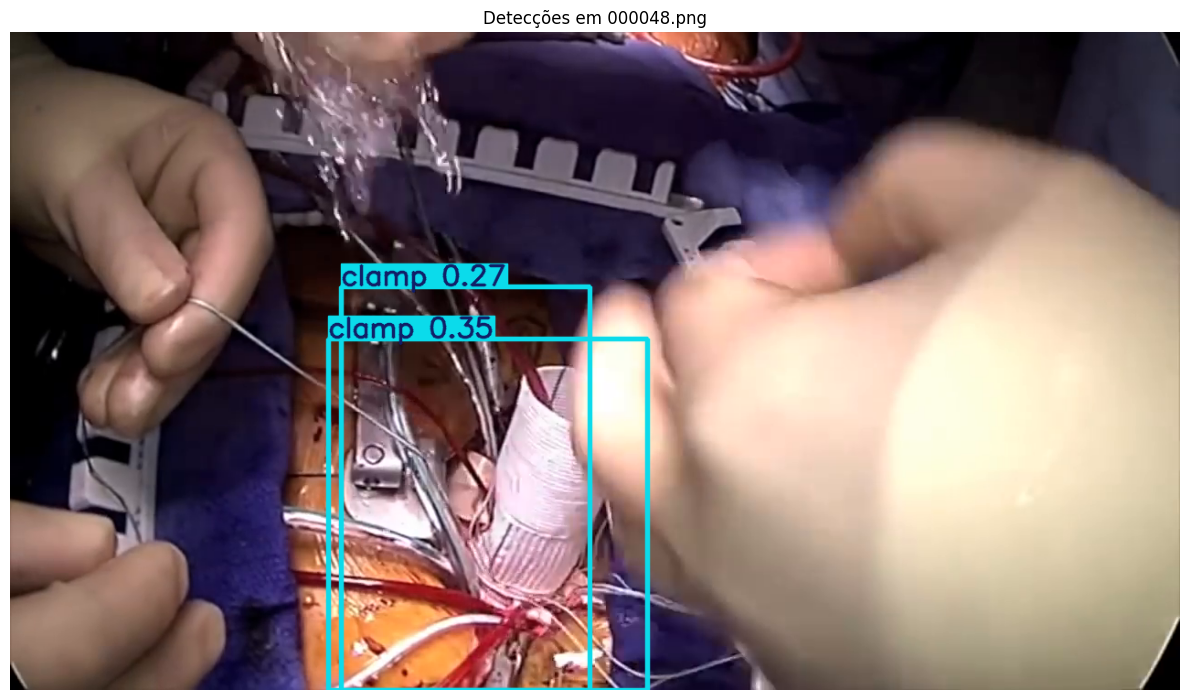

In [22]:
%matplotlib inline
import random
from pathlib import Path
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Configurar caminhos
photo_dir = Path("surgical_hands_release/images")

# Seleção aleatória em subpastas
subfolders = [f for f in photo_dir.iterdir() if f.is_dir()]
random_subfolder = random.choice(subfolders)
image_files = list(random_subfolder.glob("*.jpg")) + list(random_subfolder.glob("*.png"))
random_image_path = random.choice(image_files)

# Carregar modelo e imagem
model = YOLO("/mounts/grupo1/yolo_models/yoloTrackingWithHands2.pt")
frame = cv2.imread(str(random_image_path))

if frame is None:
    print("Erro ao carregar imagem")
else:
    # Fazer detecção
    results = model(frame)
    
    # Converter BGR para RGB e plotar
    result_img = results[0].plot()  # Já retorna imagem em BGR
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Detecções em {random_image_path.name}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
